In [1]:
import os
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

import torch
from time import time

# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) ## for Dark plots
#jtplot.style(theme='grade3')  ## for Light plots

In [2]:
import sys
sys.path.insert(1, '/home/james/code/hw-aware-eprop')
from hw_aware_eprop.models import *

## Define hyperparameters

In [3]:
params= {
    'dtype'     : torch.float32,
    'n_batch'     : 1,             # batch size of the testing set
    'n_out'       : 1,             # number of output neurons (number of target curves)
    'n_in'        : 100 ,          # number of input units
    'n_rec'       : 100,           # number of recurrent units

    'f0'          : 50 ,           # input firing rate
    'reg_rate'    : 10 ,           # target rate for regularization

    'n_iter'      : 2000 ,         # number of iterations/epochs
    'seq_len'     : 1000  ,         # number of time steps per sequence
    'print_every' : 10  ,          # print statistics every K iterations

    'dampening_factor' : 0.3,      # dampening factor to stabilize learning in RNNs
    'learning_rate'  : 1e-4,       # learning rate
    'reg'         : 300,           # regularization coefficient

    'dt'          : 1. ,           # (ms) simulation step
    'thr'         : 0.03,          # threshold at which the LSNN neurons spike (in arbitrary units)

    'do_plot'     : True,          # interactive plots during training
    'random_feedback' : False,     # use random feedback if true, otherwise take the symmetric of the readout weights
    'stop_z_gradients' : True,    # stop gradients in the model dynamics to get mathematical equivalence between eprop and BPTT
    'gradient_check' : True,       # verify that the gradients computed with e-prop match the gradients of BPTT
    'eprop_or_bptt' : 'eprop',     # choose the learing rule, it should be `eprop` of `bptt`'
    }

# explicitate some of the parameters to lighten syntax
dtype = params['dtype']

# Experiment parameters
dt = 1  # time step in ms
input_f0 = params['f0'] / 1000  # input firing rate in kHz in coherence with the usage of ms for time
regularization_f0 = params['reg_rate'] / 1000  # desired average firing rate in kHz
tau_m = tau_m_readout = 30
thr = params['thr']
params['tau_m'] = tau_m
params['tau_m_readout'] = tau_m_readout
params['regularization_f0'] = regularization_f0

## Define LIF neuron

In [4]:
cell = LightLIF(n_in=params['n_in'], n_rec=params['n_rec'], tau=tau_m, thr=thr, dt=dt,
                dampening_factor=params['dampening_factor'],
                stop_z_gradients=params['stop_z_gradients'])

#cell.w_in_var = torch.nn.Parameter( torch.from_numpy( w_in_tf ).type(dtype=dtype) )
#cell.w_rec_var = torch.nn.Parameter( torch.from_numpy( w_rec_tf ).type(dtype=dtype) )

## Visualise input and output data (spikes)

In [5]:
# build the input pattern
# dimentions: [batch=1, time_steps=1000, neurons=1]
frozen_poisson_noise_input = np.random.rand(params['n_batch'], params['seq_len'], params['n_in']) < dt * input_f0  # why sampling period * input frequency? = [spikes]
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )

# build the output pattern (note that the [None,:] adds an extra dimension of size 1 to the tensor)
# dimentions: [batch=1, time_steps=1000, neurons=1]
target_sinusoidal_outputs = [sum_of_sines_target(params['seq_len'])[None, :] for i in range(params['n_out'])]
target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=dtype)
#target_sinusoidal_outputs = torch.from_numpy(target_sinusoidal_outputs_tf).type(dtype=dtype)

In [6]:
frozen_poisson_noise_input[:,:,0].shape

(1, 1000)

Text(0.5, 1.0, 'Input spikes for 0th input neuron')

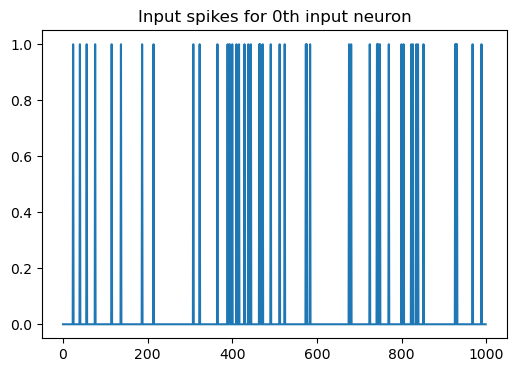

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(frozen_poisson_noise_input[0,:,0])  # First batch, all time points, for 0th input neuron
plt.title("Input spikes for 0th input neuron")

In [8]:
target_sinusoidal_outputs[0,:,0].shape

torch.Size([1000])

Text(0.5, 1.0, 'Output target for 0th output neuron')

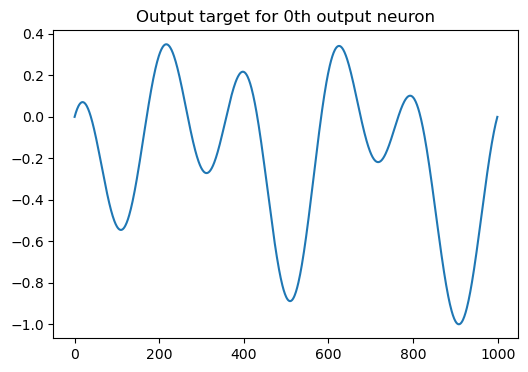

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(target_sinusoidal_outputs[0,:,0])  # First batch, all time points, for 0th input neuron
plt.title("Output target for 0th output neuron")

In [10]:
target_sinusoidal_outputs.shape

torch.Size([1, 1000, 1])

## Define forward, loss and eligibility trace computation functions

In [11]:
def forward( input_spikes, dtype=torch.float32 ):
    '''
    Simply computing the forward pass
    '''
    state = cell.zero_state(input_spikes.size(0), dtype=dtype)
    z, v = [], []
    for t in range( input_spikes.size(1) ):
        out, state = cell( input_spikes[:,t], state )
        z.append(out[0]); v.append(out[1])
    z = torch.stack(z, dim=1)
    v = torch.stack(v, dim=1)
    return z, v 

def compute_loss( z, w_out, target_sinusoidal_outputs ):
    output_current = torch.einsum('bti,ik->btk', z, w_out)
    readout_decay = torch.tensor( np.exp(-params['dt'] / params['tau_m_readout']) ).float()
    output = exp_convolve(output_current, decay=readout_decay)
    output_error = output - target_sinusoidal_outputs
    # MSE loss
    loss = 0.5 * torch.sum(output_error ** 2)

    # regularization loss reducing the spiking activity
    av = torch.mean(z, dim=(0, 1)) / params['dt']
    average_firing_rate_error = av - params['regularization_f0']
    loss_reg = 0.5 * torch.sum(average_firing_rate_error ** 2)

    overall_loss = loss_reg * params['reg'] + loss
    return overall_loss, average_firing_rate_error, output_error, output_error

def calculate_true_gradient( overall_loss ):
    '''
    Takes the loss function as input and produces the 
    gradient calculated with the surrogate gradient technique
    '''
    var_list = [cell.w_in_var, cell.w_rec_val, w_out]
    return torch.autograd.grad(overall_loss, var_list, retain_graph=True), var_list

def calculate_eligibility_trace( v, z, output_error, average_firing_rate_error, device='cap' ):
    '''
    Performs the calculation of the gradient in a simular fashion than e-prop
    '''
    v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
    post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
    z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)

    if device == 'cap':
        pre_term_w_in = exp_convolve(input_spikes, decay=cell._decay)
        pre_term_w_rec = exp_convolve(z_previous_time, decay=cell._decay)
        pre_term_w_out = exp_convolve(z, decay=cell._decay)
    else:
        # for PCMprop develop next lines
        pre_term_w_in  = pcm_convolve(input_spikes, delta_g=(1-cell._decay)/2)
        pre_term_w_rec = pcm_convolve(z_previous_time, delta_g=(1-cell._decay)/2)
        pre_term_w_out = pcm_convolve(z, delta_g=(1-cell._decay)/2)

    eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
    eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

    # To define the gradient of the readout error,
    # the eligibility traces are smoothed with the same filter as the readout
    eligibility_traces_convolved_w_in = exp_convolve(eligibility_traces_w_in, decay=readout_decay)
    eligibility_traces_convolved_w_rec = exp_convolve(eligibility_traces_w_rec, decay=readout_decay)

    # To define the gradient of the regularization error defined on the averaged firing rate,
    # the eligibility traces should be averaged over time
    eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, axis=(0, 1))
    eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, axis=(0, 1))

    if params['random_feedback']:
        B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=params['dtype'])
    else:
        B_random = w_out.clone() # better performance is obtained with the true error feed-backs
    learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

    # gradients of the main loss with respect to the weights
    dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], axis=(0, 1))
    dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, axis=(0, 1))
    dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, axis=(0, 1))

    # gradients of the regularization loss with respect to the weights
    dreg_loss_dw_in = average_firing_rate_error * eligibility_traces_averaged_w_in
    dreg_loss_dw_rec = average_firing_rate_error * eligibility_traces_averaged_w_rec

    # combine the gradients
    dloss_dw_in = dloss_dw_in + dreg_loss_dw_in * params['reg']
    dloss_dw_rec = dloss_dw_rec + dreg_loss_dw_rec * params['reg']

    # Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
    mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
    dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

    # put the resulting gradients into lists
    var_list = [cell.w_in_var, cell.w_rec_val, w_out]
    eprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]
    return eprop_gradients, var_list
        
        
def calculate_eligibility_trace_pcm( v, z, output_error, average_firing_rate_error ):
    '''
    Performs the calculation of the gradient in a simular fashion than e-prop
    '''
    v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
    post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
    z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)
    
    # for PCMprop develop next lines
    pre_term_w_in  = pcm_convolve(input_spikes, delta_g=(1-cell._decay)/2)
    pre_term_w_rec = pcm_convolve(z_previous_time, delta_g=(1-cell._decay)/2)
    pre_term_w_out = pcm_convolve(z, delta_g=(1-cell._decay)/2)

    eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
    eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

    # To define the gradient of the readout error,
    # the eligibility traces are smoothed with the same filter as the readout
    eligibility_traces_convolved_w_in = pcm_convolve(eligibility_traces_w_in, decay=readout_decay)
    eligibility_traces_convolved_w_rec = pcm_convolve(eligibility_traces_w_rec, decay=readout_decay)

    # To define the gradient of the regularization error defined on the averaged firing rate,
    # the eligibility traces should be averaged over time
    eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, axis=(0, 1))
    eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, axis=(0, 1))

    if params['random_feedback']:
        B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=params['dtype'])
    else:
        B_random = w_out.clone() # better performance is obtained with the true error feed-backs
    learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

    # gradients of the main loss with respect to the weights
    dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], axis=(0, 1))
    dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, axis=(0, 1))
    dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, axis=(0, 1))

    # gradients of the regularization loss with respect to the weights
    dreg_loss_dw_in = average_firing_rate_error * eligibility_traces_averaged_w_in
    dreg_loss_dw_rec = average_firing_rate_error * eligibility_traces_averaged_w_rec

    # combine the gradients
    dloss_dw_in = dloss_dw_in + dreg_loss_dw_in * params['reg']
    dloss_dw_rec = dloss_dw_rec + dreg_loss_dw_rec * params['reg']

    # Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
    mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
    dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

    # put the resulting gradients into lists
    var_list = [cell.w_in_var, cell.w_rec_var, w_out]
    pcmprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]

    return pcmprop_gradients, var_list

def weight_update_SGD( eprop_gradients, var_list ):
    '''
    performing the weight update
    '''
    with torch.no_grad():
        for v, var in enumerate(var_list): 
            var -= params['learning_rate'] * eprop_gradients[v]
            var.grad = None

# SINGLE TRAIN EPOCH, FOR DEBUGGING

In [12]:
#### SINGLE TRAIN EPOCH, FOR DEBUGGING ####

# Example of forward pass with the LIF neuron module
state = cell.zero_state(input_spikes.size(0), dtype=dtype)
z, v = [], []
for t in range( input_spikes.size(1) ):
    out, state = cell( input_spikes[:,t], state )
    z.append(state.z); v.append(state.v)
z = torch.stack(z, dim=1)  # So is this stacking every epoch? 
v = torch.stack(v, dim=1)

# output loss
w_out = torch.nn.Parameter( torch.randn( params['n_rec'], params['n_out'] )/np.sqrt( params['n_rec'] ) ).type(dtype=dtype)
#w_out = torch.nn.Parameter( torch.from_numpy( w_out_tf ).type(dtype=dtype) )
output_current = torch.einsum('bti,ik->btk', z, w_out)
readout_decay = torch.tensor( np.exp(-params['dt'] / params['tau_m_readout']) ).float()
output = exp_convolve(output_current, decay=readout_decay)
output_error = output - target_sinusoidal_outputs
loss = 0.5 * torch.sum(output_error ** 2)

# regularization loss
av = torch.mean(z, dim=(0, 1)) / params['dt']
average_firing_rate_error = av - regularization_f0
loss_reg = 0.5 * torch.sum(average_firing_rate_error ** 2)

overall_loss = loss_reg * params['reg'] + loss

In [13]:
print(z[0].shape, type(z[0]))
print(z[0,:].shape, type(z[0,:]))
print(z[0,1].shape, type(z[0,1]))

torch.Size([1000, 100]) <class 'torch.Tensor'>
torch.Size([1000, 100]) <class 'torch.Tensor'>
torch.Size([100]) <class 'torch.Tensor'>


Initial Loss: 111.9047


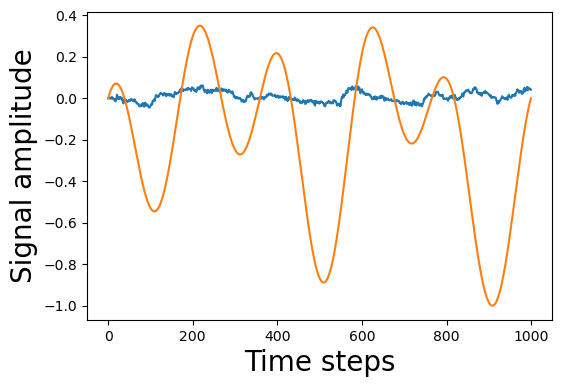

In [14]:
plt.figure('signals', (6,4))
plt.plot( output[0].detach().numpy() )
plt.plot( target_sinusoidal_outputs[0].detach().numpy() )
plt.xlabel( 'Time steps',size=20 )
plt.ylabel( 'Signal amplitude',size=20 )
print( 'Initial Loss: {:.4f}'.format( compute_loss( z, w_out, target_sinusoidal_outputs )[0] ) )

In [15]:
v.max(), v.min()

(tensor(0.0663, grad_fn=<MaxBackward1>),
 tensor(-0.2980, grad_fn=<MinBackward1>))

## Calculate e-prop gradients

In [16]:
# Calculation of the Eligibility Trace
v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)

pre_term_w_in = exp_convolve(input_spikes, decay=cell._decay)  # Why do we need to decay the input spikes?
pre_term_w_rec = exp_convolve(z_previous_time, decay=cell._decay)
pre_term_w_out = exp_convolve(z, decay=cell._decay)

# for PCMprop develop next lines
#pre_term_w_in = pcm_convolve(input_spikes, nu)
#pre_term_w_rec = pcm_convolve(z_previous_time, nu)
#pre_term_w_out = pcm_convolve(z, nu)

eligibility_traces_w_in = post_term[:, :, None, :] * pre_term_w_in[:, :, :, None]
eligibility_traces_w_rec = post_term[:, :, None, :] * pre_term_w_rec[:, :, :, None]

# To define the gradient of the readout error,
# the eligibility traces are smoothed with the same filter as the readout
eligibility_traces_convolved_w_in = exp_convolve(eligibility_traces_w_in, decay=readout_decay)
eligibility_traces_convolved_w_rec = exp_convolve(eligibility_traces_w_rec, decay=readout_decay)

# To define the gradient of the regularization error defined on the averaged firing rate,
# the eligibility traces should be averaged over time
eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, dim=(0, 1))
eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, dim=(0, 1))

if params['random_feedback']:
    B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=dtype)
else:
    B_random = w_out.clone() # better performance is obtained with the true error feed-backs
learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

# gradients of the main loss with respect to the weights
dloss_dw_out = torch.sum(output_error[:, :, None, :] * pre_term_w_out[:, :, :, None], dim=(0, 1))
dloss_dw_in = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in, dim=(0, 1))
dloss_dw_rec = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec, dim=(0, 1))

# gradients of the regularization loss with respect to the weights
dreg_loss_dw_in = average_firing_rate_error * eligibility_traces_averaged_w_in
dreg_loss_dw_rec = average_firing_rate_error * eligibility_traces_averaged_w_rec
input_spikes
# combine the gradients
dloss_dw_in += dreg_loss_dw_in * params['reg']
dloss_dw_rec += dreg_loss_dw_rec * params['reg']

# Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
dloss_dw_rec = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec), dloss_dw_rec)

# put the resulting gradients into lists
var_list = [cell.w_in_var, cell.w_rec_var, w_out]
true_gradients = torch.autograd.grad(overall_loss, var_list, retain_graph=True)
eprop_gradients = [dloss_dw_in, dloss_dw_rec, dloss_dw_out]

# performing the weight update
#with torch.no_grad():
#    for n, var in enumerate(var_list): 
#        var -= params['learning_rate'] * eprop_gradients[n]

## Repeat e-prop gradient calculations for PCM?

In [17]:
# Calculation of the Eligibility Trace
v_scaled = (v - params['thr']) / params['thr'] # voltage scaled to be 0 at threshold and -1 at rest
post_term = pseudo_derivative(v_scaled, params['dampening_factor']) / params['thr'] # non-linear function of the voltage
z_previous_time = shift_by_one_time_step(z) # z(t-1) instead of z(t)

# for PCMprop develop next lines
pre_term_w_in_pcm  = pcm_convolve(input_spikes, delta_g=(1-cell._decay)/2)
pre_term_w_rec_pcm = pcm_convolve(z_previous_time, delta_g=(1-cell._decay)/2)
pre_term_w_out_pcm = pcm_convolve(z, delta_g=(1-cell._decay)/2)

eligibility_traces_w_in_pcm = post_term[:, :, None, :] * pre_term_w_in_pcm[:, :, :, None]
eligibility_traces_w_rec_pcm = post_term[:, :, None, :] * pre_term_w_rec_pcm[:, :, :, None]

# Unsure about these extra processing steps?

# To define the gradient of the readout error,
# the eligibility traces are smoothed with the same filter as the readout
eligibility_traces_convolved_w_in_pcm = exp_convolve(eligibility_traces_w_in_pcm, decay=readout_decay)
eligibility_traces_convolved_w_rec_pcm = exp_convolve(eligibility_traces_w_rec_pcm, decay=readout_decay)

# To define the gradient of the regularization error defined on the averaged firing rate,
# the eligibility traces should be averaged over time
eligibility_traces_averaged_w_in = torch.mean(eligibility_traces_w_in, dim=(0, 1))
eligibility_traces_averaged_w_rec = torch.mean(eligibility_traces_w_rec, dim=(0, 1))

if params['random_feedback']:
    B_random = torch.from_numpy(np.random.randn(params['n_rec'], params['n_out']) / np.sqrt(params['n_rec']) ).type(dtype=dtype)
else:
    B_random = w_out.clone() # better performance is obtained with the true error feed-backs
learning_signals = torch.einsum('btk,jk->btj', output_error, B_random)

# gradients of the main loss with respect to the weights
dloss_dw_out_pcm = torch.sum(output_error[:, :, None, :] * pre_term_w_out_pcm[:, :, :, None], dim=(0, 1))
dloss_dw_in_pcm = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_in_pcm, dim=(0, 1))
dloss_dw_rec_pcm = torch.sum(learning_signals[:, :, None, :] * eligibility_traces_convolved_w_rec_pcm, dim=(0, 1))

# gradients of the regularization loss with respect to the weights
dreg_loss_dw_in_pcm = average_firing_rate_error * eligibility_traces_convolved_w_in_pcm
dreg_loss_dw_rec_pcm = average_firing_rate_error * eligibility_traces_convolved_w_rec_pcm

# combine the gradients
dloss_dw_in_pcm += dreg_loss_dw_in * params['reg']
dloss_dw_rec_pcm += dreg_loss_dw_rec * params['reg']

# Somewhat important detail: self connection are disabled therefore gradients on the diagonal are zeros
mask_autotapse = torch.diag(torch.ones(params['n_rec'])).bool()
dloss_dw_rec_pcm = torch.where(mask_autotapse, torch.zeros_like(dloss_dw_rec_pcm), dloss_dw_rec_pcm)

# put the resulting gradients into lists
var_list = [cell.w_in_var, cell.w_rec_var, w_out]
true_gradients = torch.autograd.grad(overall_loss, var_list, retain_graph=True)
pcmprop_gradients = [dloss_dw_in_pcm, dloss_dw_rec_pcm, dloss_dw_out_pcm]

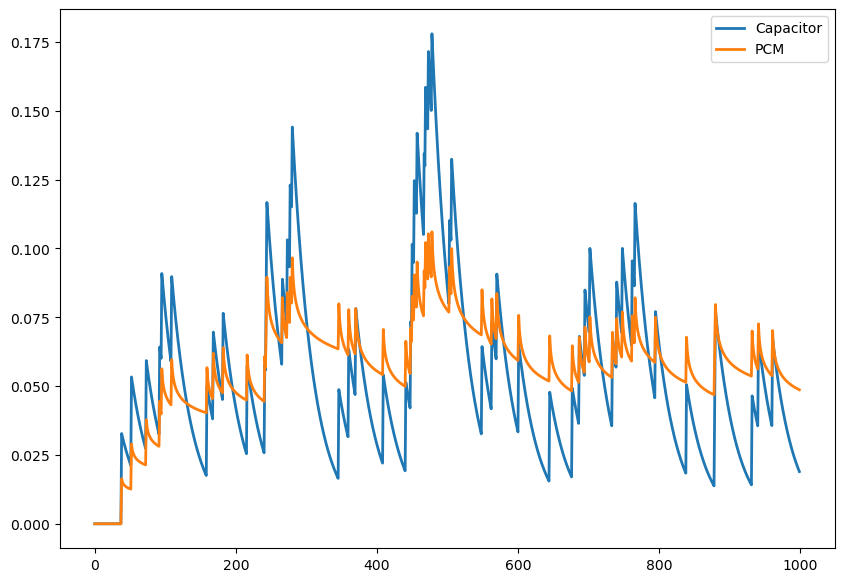

In [18]:
plt.figure( 'pcm vs cap', (10,7) )
plt.plot( pre_term_w_in.detach().numpy()[0,:,10], linewidth=2, label='Capacitor' )
plt.plot( pre_term_w_in_pcm.detach().numpy()[0,:,10], linewidth=2, label='PCM' )
plt.legend()

In [19]:
torch.sum((true_gradients[2] - eprop_gradients[2])**2)

tensor(2.0177e-10, grad_fn=<SumBackward0>)

In [20]:
torch.sum((true_gradients[0] - eprop_gradients[0])**2)

tensor(2.6153e-09, grad_fn=<SumBackward0>)

In [21]:
torch.mean( (eprop_gradients[1] - pcmprop_gradients[1])**2 )

tensor(0., grad_fn=<MeanBackward0>)

# Learning Loop

In [22]:
params['eprop_or_bptt'] = 'eprop'
params['stop_z_gradients'] = True
params['random_feedback'] = False
params['learning_rate'] = 1e-3

cell = LightLIF(n_in=params['n_in'], n_rec=params['n_rec'], tau=tau_m, thr=thr, dt=dt,
                dampening_factor=params['dampening_factor'],
                stop_z_gradients=params['stop_z_gradients'])

w_out = torch.nn.Parameter( torch.randn( params['n_rec'], params['n_out'] )
                           /np.sqrt( params['n_rec'] ) ).type(dtype=dtype)


In [23]:
loss_hist_eprop = []
t_train = 0
for k_iter in range(100):
    # train
    t0 = time()
    z, v = forward( input_spikes )
    overall_loss, average_firing_rate_error, output_error, output = compute_loss( z, w_out, target_sinusoidal_outputs )
    loss_hist_eprop.append( overall_loss.item() )
    if params['eprop_or_bptt'] == 'bptt':
        gradients, var_list = calculate_true_gradient(overall_loss)
    elif params['eprop_or_bptt'] == 'eprop':
        gradients, var_list = calculate_eligibility_trace(v,z, output_error, average_firing_rate_error)
    elif params['eprop_or_bptt'] == 'pcmprop':
        gradients, var_list = calculate_eligibility_trace_pcm(v,z, output_error, average_firing_rate_error )
    weight_update_SGD( gradients, var_list )
    t_train = time() - t0

In [24]:
from copy import deepcopy
eprop_wout = deepcopy(w_out)

In [25]:
# params['eprop_or_bptt'] = 'pcmprop'
# params['stop_z_gradients'] = True
# params['random_feedback'] = False
# params['learning_rate'] = 1e-3

# cell = LightLIF(n_in=params['n_in'], n_rec=params['n_rec'], tau=tau_m, thr=thr, dt=dt,
#                 dampening_factor=params['dampening_factor'],
#                 stop_z_gradients=params['stop_z_gradients'])

# w_out = torch.nn.Parameter( torch.randn( params['n_rec'], params['n_out'] )
#                            /np.sqrt( params['n_rec'] ) ).type(dtype=dtype)

In [26]:
# loss_hist_pcmprop = []
# t_train = 0
# for k_iter in range(100):
#     t0 = time()
#     z, v = forward( input_spikes )
#     overall_loss, average_firing_rate_error, output_error, output = compute_loss( z, w_out, target_sinusoidal_outputs )
#     loss_hist_pcmprop.append( overall_loss.item() )
#     gradients, var_list = calculate_eligibility_trace(v,z, output_error, average_firing_rate_error, device='pcm')
#     weight_update_SGD( gradients, var_list )
#     t_train = time() - t0

Text(0, 0.5, 'MSE Loss')

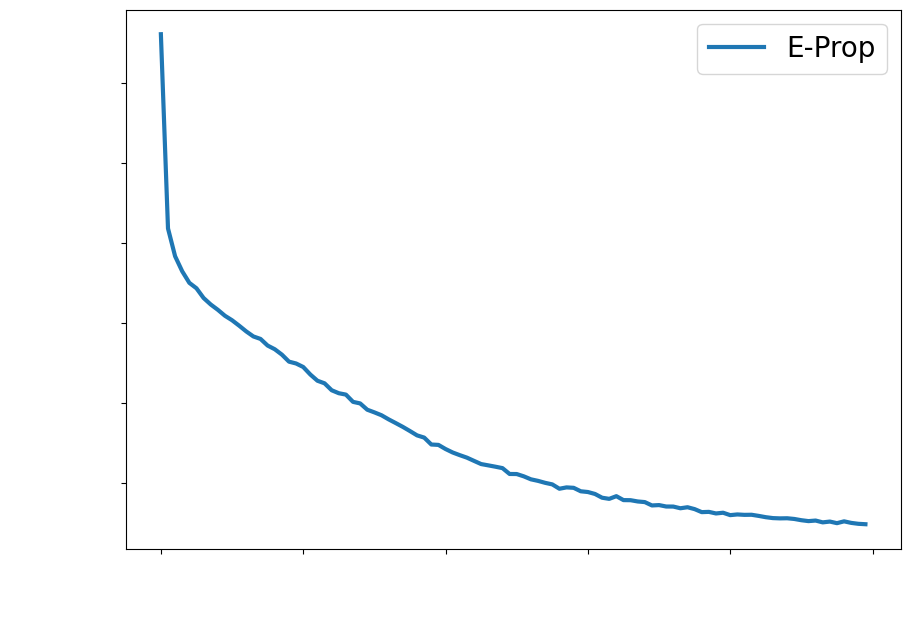

In [27]:
textcolor = 'w'
plt.figure('Eprop vs PCMprop', (10,7))
plt.plot( loss_hist_eprop, linewidth=3, label='E-Prop' )
# plt.plot( loss_hist_pcmprop, linewidth=3, label='PCM-Prop' )
plt.legend(prop={'size':20})
plt.tick_params(labelsize=25, labelcolor=textcolor)
plt.xlabel('Iterations', size=25, color=textcolor)
plt.ylabel('MSE Loss', size=25, color=textcolor)

In [28]:
z, v = forward( input_spikes )
output_current = torch.einsum('bti,ik->btk', z, eprop_wout)
output_eprop = exp_convolve(output_current, decay=readout_decay)

In [29]:
# z, v = forward( input_spikes )
# output_current = torch.einsum('bti,ik->btk', z, w_out)
# output_pcm = exp_convolve(output_current, decay=readout_decay)

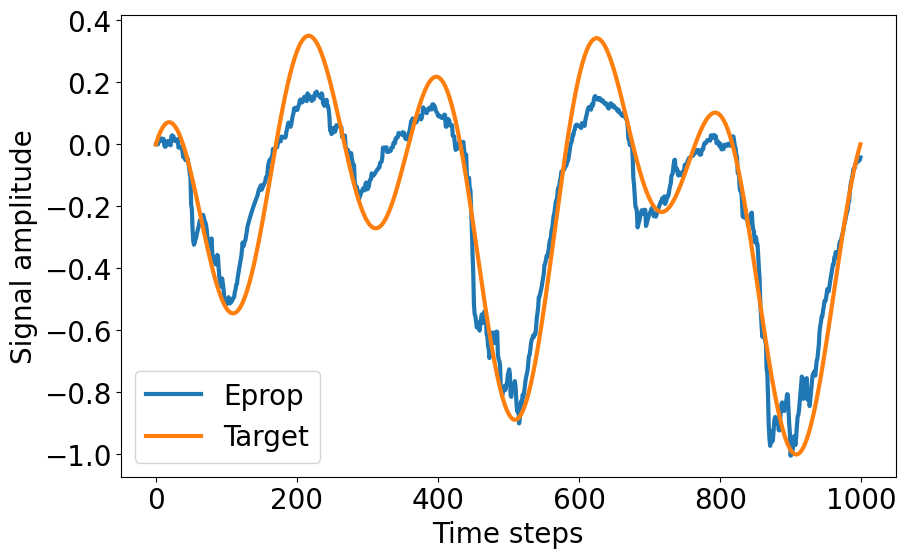

In [30]:
textcolor = 'k'
plt.figure('signals', (10,6))
plt.plot( output_eprop[0].detach().numpy(), linewidth=3, label='Eprop' )
# plt.plot( output_pcm[0].detach().numpy(), linewidth=3, label='PCM-prop' )
plt.plot( target_sinusoidal_outputs[0].detach().numpy(), linewidth=3, label='Target' )
plt.xlabel( 'Time steps',size=20, color=textcolor )
plt.ylabel( 'Signal amplitude',size=20, color=textcolor )
plt.tick_params(labelsize=20, labelcolor=textcolor)
plt.legend(prop={'size':20})
#print( 'Loss: {:.4f}'.format( compute_loss( z, w_out, target_sinusoidal_outputs )[0] ) )

# Probe network

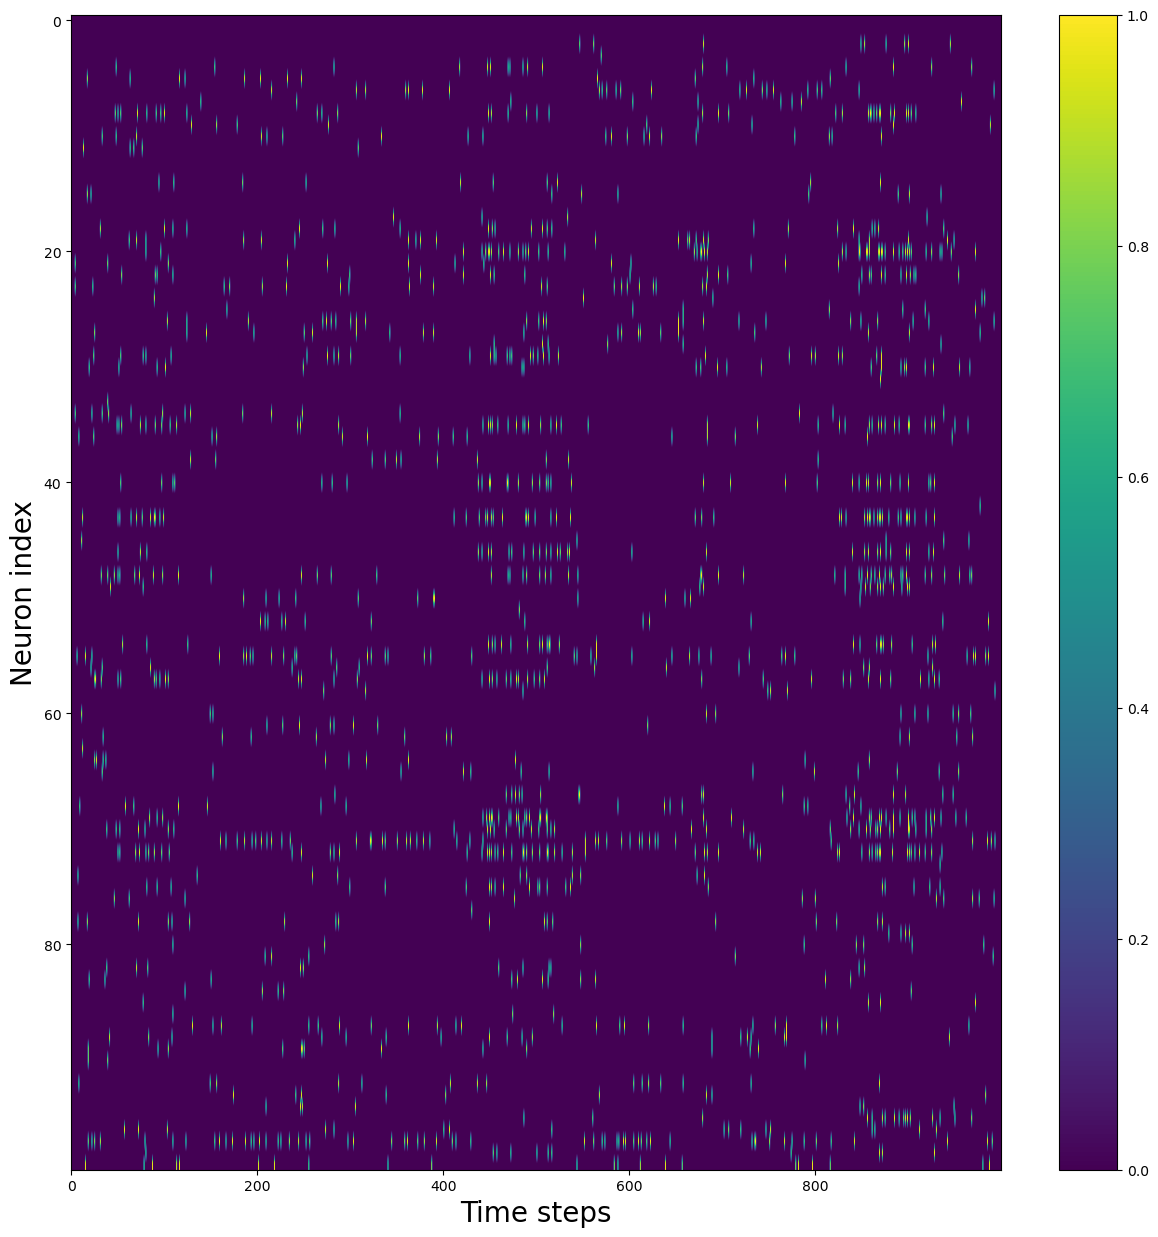

In [31]:
# Plot spikes for all recurrent neurons
plt.figure(figsize=(15, 15))
plt.imshow(z[0].detach().numpy().T, aspect='auto')
plt.xlabel('Time steps', size=20, color=textcolor)
plt.ylabel('Neuron index', size=20, color=textcolor)
plt.colorbar()

In [32]:
z.shape

torch.Size([1, 1000, 100])

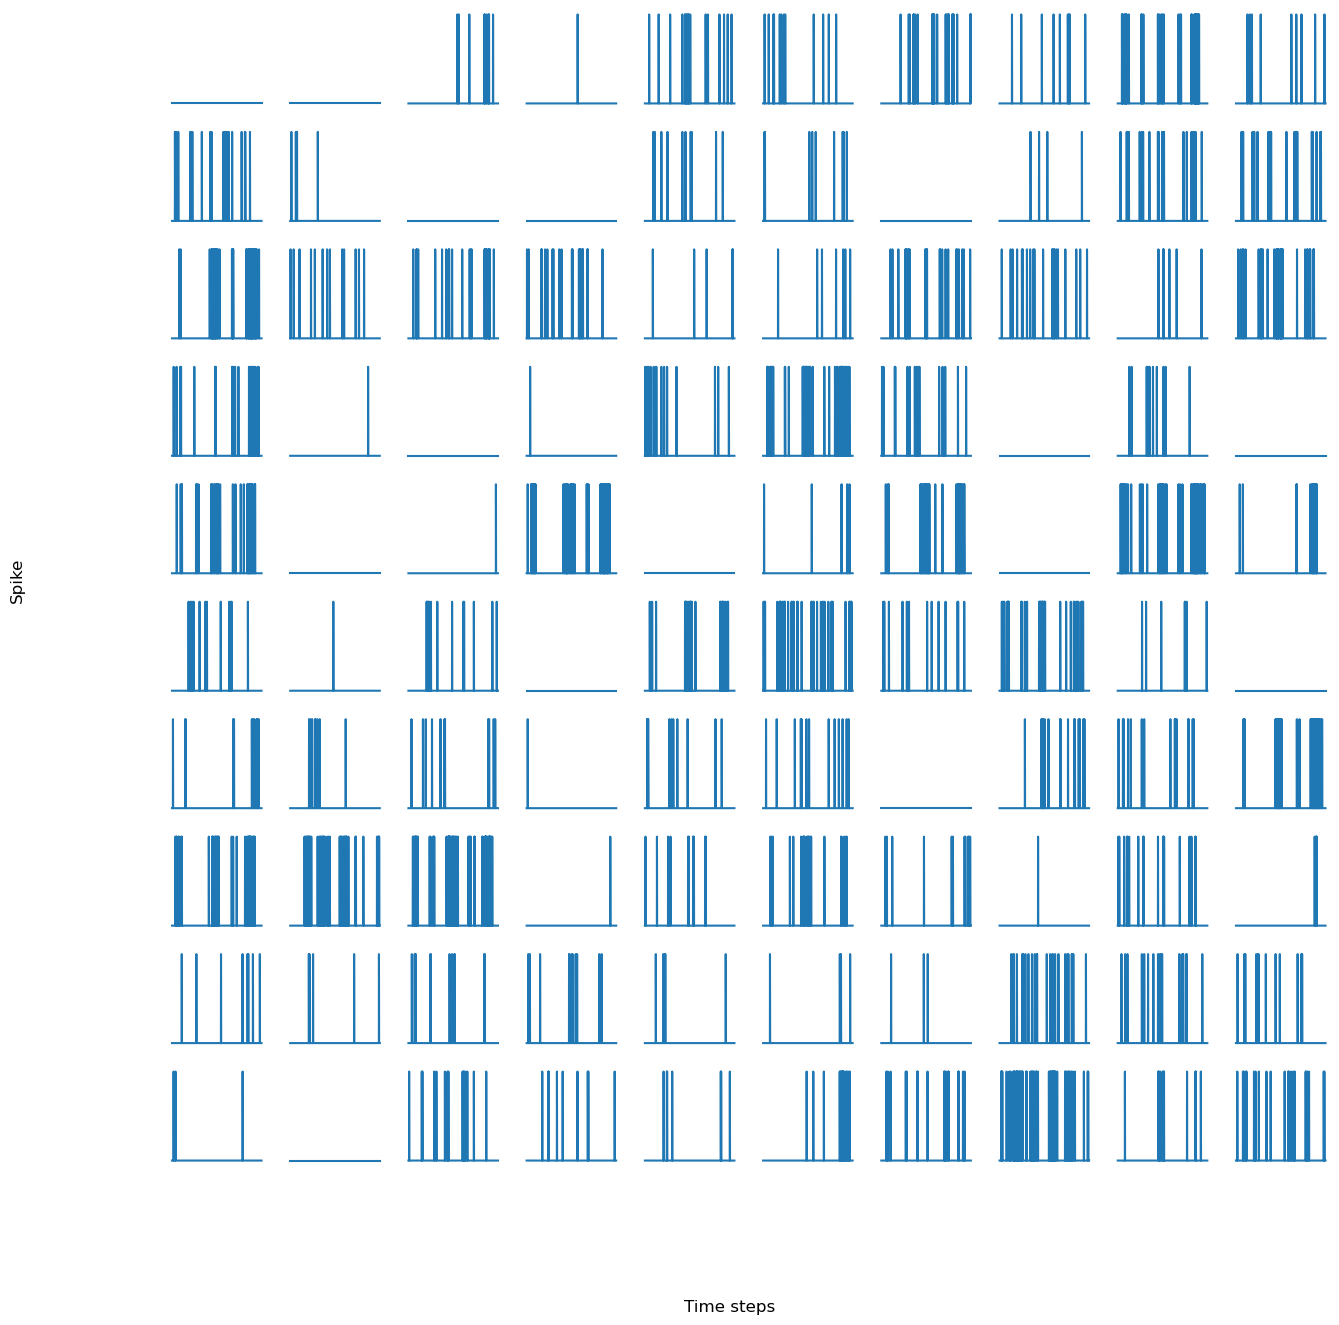

In [33]:
# Create a subplot grid with 10 rows and 10 columns
fig, ax = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)
# Iterate over each subplot and plot the z spikes
for i in range(10):
    for j in range(10):
        ax[i, j].plot(z[0,:,i*10 + j].detach())
        ax[i,j].axis('off')

fig.supxlabel('Time steps')
fig.supylabel('Spike')

# Show the plot
plt.show()


In [34]:
target_sinusoidal_outputs = [sum_of_sines_target(1000)[None, :] for i in range(params['n_out'])]
target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=dtype)

# Learning loop with interactive plot

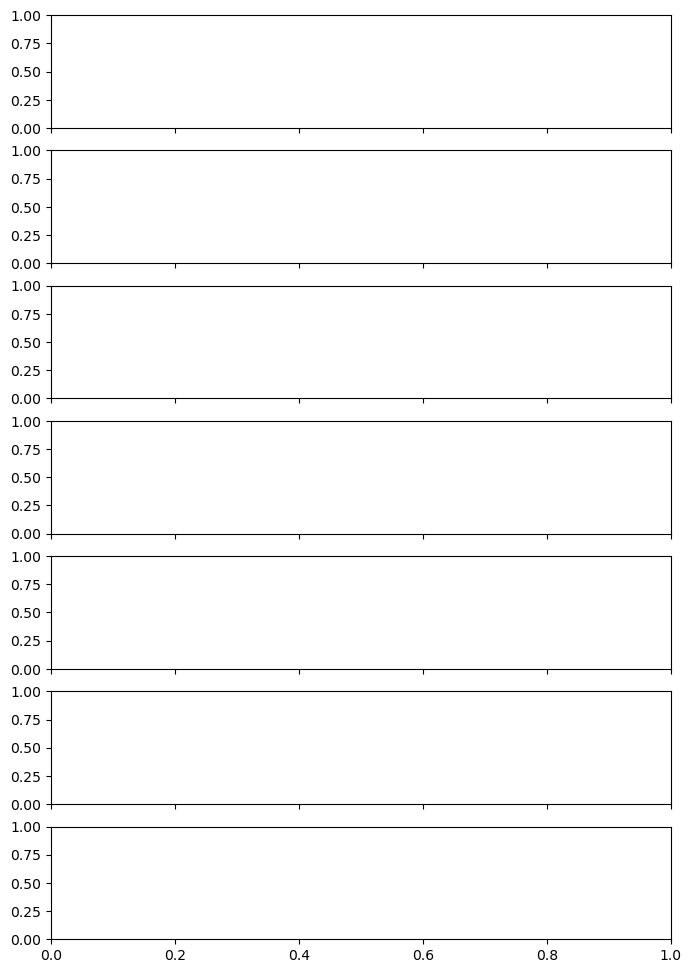

In [35]:
# Open an interactive matplotlib window to plot in real time
if params['do_plot']:
    plt.ion()
    fig, ax_list = plt.subplots(2 + params['n_out'] + 4, figsize=(8, 12), sharex=True)

In [36]:
def update_plot(plot_result_values, batch=0, n_max_neuron_per_raster=40):
    """
    This function iterates the matplotlib figure on every call.
    It plots the data for a fixed sequence that should be representative of the expected computation
    :return:
    """

    # Clear the axis to print new plots
    for k in range(ax_list.shape[0]):
        ax = ax_list[k]
        ax.clear()

    # PLOT Input signals
    for k, spike_ref in enumerate(['input_spikes', 'z']):
        spikes = plot_result_values[spike_ref][batch]

        spikes = spikes[:, :n_max_neuron_per_raster]
        ax = ax_list[k]

        ax.imshow(spikes.T, aspect='auto', cmap='hot_r')
        ax.set_xlim([0, FLAGS.seq_len])
        ax.set_ylabel(spike_ref)

    output = plot_result_values['output'][batch]
    for i in range(output.shape[1]):
        ax = ax_list[i + 2]
        ax.set_yticks([-1, 0, 1])
        # ax.set_ylim([-1., 1.])
        ax.set_ylabel('Output')

        ax.plot(np.arange(FLAGS.seq_len), target_sinusoidal_outputs[batch, :, i], linestyle='dashed', label='Target',
                alpha=0.8)
        ax.plot(np.arange(FLAGS.seq_len), output[:, i], linestyle='solid', label='Target', alpha=0.8)

        ax.set_xlim([0, FLAGS.seq_len])

    el_data_list = []
    i_pre = j_post = 0
    while i_pre == j_post or np.all(el_data_list[2] == 0):
        # choose i and j to find an interesting synapse representative of what is happening
        i_pre = np.random.randint(FLAGS.n_rec)
        j_post = np.random.randint(FLAGS.n_rec)
        el_data_list = [results_values['pre_term'][batch, :, i_pre],
                        results_values['post_term'][batch, :, j_post],
                        results_values['eligibility_traces'][batch, :, i_pre, j_post],
                        results_values['learning_signals'][batch, :, j_post],
                        ]

    name_list = ['term pre',
                 'term post',
                 'eligibility trace',
                 'learning signal']

    for k, name, data in zip(range(len(name_list)), name_list, el_data_list):
        ax = ax_list[2 + FLAGS.n_out + k]
        ax.plot(np.arange(FLAGS.seq_len), data)
        ax.set_xlim([0, FLAGS.seq_len])
        ax.set_ylabel(name)

    ax_list[2 + n_out + 0].set_ylim([0, 0.25])
    ax_list[2 + n_out + 1].set_ylim([0, 10.])
    ax_list[2 + n_out + 2].set_ylim([0, 1.])
    ax_list[2 + n_out + 3].set_ylim([-0.08, 0.08])

    ax.set_xlabel('Time in ms')
    # To plot with interactive python one need to wait one second to the time to draw the axis
    if do_plot:
        plt.draw()
        plt.pause(0.1)

In [37]:
# Loss list to store the loss over itertaions
loss_list = []
t_train = 0
for k_iter in range(n_iter):

    # train
    t0 = time()
    # optimizer.zero_grad()
    z, v = forward( input_spikes )
    w_out = torch.nn.Parameter( torch.randn( n_rec, n_out )/np.sqrt( n_rec ) ).type(dtype=dtype)
    overall_loss = compute_loss( w_out, target_sinusoidal_outputs )
    if params['eprop_or_bptt'] == 'bptt':
        gradients, var_list = calculate_true_gradient(overall_loss)
    elif params['eprop_or_bptt'] == 'eprop':
        gradients, var_list = calculate_eligibility_trace(overall_loss)
    elif params['eprop_or_bptt'] == 'pcmprop':
        gradients, var_list = calculate_eligibility_trace_pcm(overall_loss)
    weight_update_SGD( gradients, var_list )
    t_train = time() - t0

    if np.mod(k_iter, print_every) == 0:

        if gradient_check:
            if not (stop_z_gradients):
                print('Gradient check is disabled because the gradients of inter neuron dependencies are not blocked.')
            elif seq_len > 20:
                print('Gradient check is disabled for sequence lengths larger than 20 time steps')
            else:
                print('Gradient check')
                eprop_grads_np, true_grads_np = sess.run([eprop_gradients, true_gradients])
                check_gradients(var_list, eprop_grads_np, true_grads_np)

        print('''Iteration {}, loss {:.3g} reg loss {:.3g}'''.format(k_iter, results_values['loss'],
                                                                     results_values['loss_reg']))
        loss_list.append(results_values['loss'])

        def get_stats(v):
            if np.size(v) == 0:
                return np.nan, np.nan, np.nan, np.nan
            min_val = np.min(v)
            max_val = np.max(v)

            k_min = np.sum(v == min_val)
            k_max = np.sum(v == max_val)

            return np.min(v), np.max(v), np.mean(v), np.std(v), k_min, k_max


        firing_rate_stats = get_stats(results_values['av'] * 1000)

        print('''
            firing rate (Hz)  min {:.0f} \t max {:.0f} \t average {:.0f} +- std {:.0f} (averaged over batches and time)
            comput. time (s)  training {:.2g} \t validation {:.2g}'''.format(
            firing_rate_stats[0], firing_rate_stats[1], firing_rate_stats[2], firing_rate_stats[3],
            t_train, t_valid,
        ))

        if do_plot:
            update_plot(results_values)

plt.ioff()
update_plot(results_values)

fig, ax_res = plt.subplots()
ax_res.plot(loss_list)
ax_res.set_xlabel('iterations')
ax_res.set_ylabel('mean square error')

plt.show()

NameError: name 'n_iter' is not defined

In [ ]:
results_tensors = {
    'loss': loss,
    'loss_reg': loss_reg,
    'overall_loss': overall_loss,

    'input_spikes': input_spikes,
    'z': z,
    'av': av,

    'pre_term': pre_term_w_rec,
    'post_term': post_term,
    'eligibility_traces': eligibility_traces_convolved_w_rec,
    'learning_signals': learning_signals,

    'output': output,
}

# PCM vs EPROP
How PCM approximations accumulate in time

In [ ]:
seq_lens = [250, 500, 750, 1000, 2000]

In [ ]:
grads_eprop = []
grads_pcmprop = []
for s,seq_len in enumerate(seq_lens):
    
    # reinitialize the cell
    cell = LightLIF(n_in=params['n_in'], n_rec=params['n_rec'], tau=tau_m, thr=thr, dt=dt,
                dampening_factor=params['dampening_factor'],
                stop_z_gradients=params['stop_z_gradients'])

    w_out = torch.nn.Parameter( torch.randn( params['n_rec'], params['n_out'] )
                               /np.sqrt( params['n_rec'] ) ).type(dtype=dtype)
    # make input and target
    frozen_poisson_noise_input = np.random.rand(params['n_batch'], seq_len, params['n_in']) < dt * input_f0
    input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )
    target_sinusoidal_outputs = [sum_of_sines_target(seq_len)[None, :] for i in range(params['n_out'])]
    target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=dtype)
    
    # Inference and loss calculation
    z, v = forward( input_spikes )
    overall_loss, average_firing_rate_error, output_error, output = compute_loss( z, w_out, target_sinusoidal_outputs )
    
    # calculate the gradients with the Eprop and PCMprop
    gradients_eprop, var_list = calculate_eligibility_trace(v,z, output_error, average_firing_rate_error)
    grads_eprop.append( gradients )
    gradients_pcm, _ = calculate_eligibility_trace(v,z, output_error, average_firing_rate_error, device='pcm')
    grads_pcmprop.append( gradients_pcm )
    

In [ ]:
grads_diff = torch.zeros( len(seq_lens) )
for s in range(len(seq_lens)):
    for i in range(len(grads_eprop[s])):
        grads_diff[s] += torch.sum( (grads_eprop[s][i] - grads_pcmprop[s][i])**2 )

In [ ]:
grads_diff

tensor([ 194855.8750,  310860.5625,  598164.4375,  767576.3750, 1971360.8750],
       grad_fn=<CopySlices>)

Text(0, 0.5, 'Normalized Gradient different')

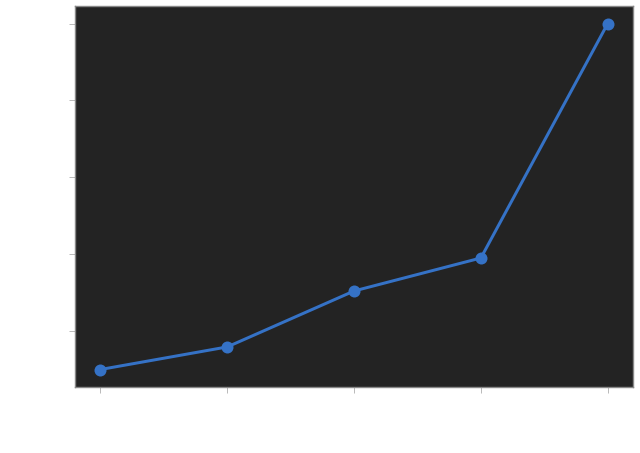

In [ ]:
textcolor = 'w'
plt.figure('grads', (10,7))
grad_norm = grads_diff.detach().numpy() / torch.max( grads_diff ).detach().numpy()
plt.plot( grad_norm, linewidth=3, marker='o', ms=12 )
plt.xticks( range(len(seq_lens)), seq_lens )
plt.tick_params( labelsize=20, labelcolor=textcolor )
plt.xlabel('Input Sequence Lenght', size=25, color=textcolor)
plt.ylabel('Normalized Gradient different', size=25, color=textcolor)